Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 119, 119, 16)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 119, 119, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                     

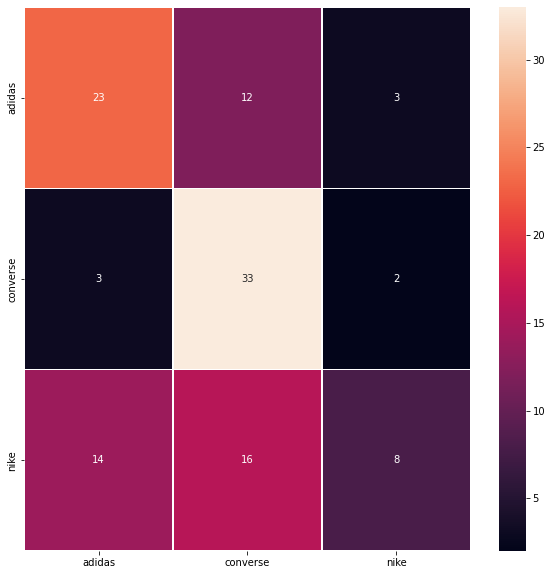

In [2]:
import pandas as pd
import google.colab.drive as drive
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from PIL import Image
import fnmatch
import os
from keras.preprocessing.image import ImageDataGenerator

def fileread(dir, pix):
  cnt=0
  for filename in os.listdir(dir):
    if fnmatch.fnmatch(filename, '*.jpg'):
      im = Image.open(dir+'/'+filename)
      pix.append(np.array(im))
      cnt = cnt+1
  return pix, cnt

def list_replace(test_list,num, word) :
  test_list =list(test_list)
  for index, item in enumerate(test_list):
    if item == num:
        test_list[index] = word
  return test_list

drive.mount('/content/drive')
base_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset'

test_adidas_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/test/adidas'
test_converse_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/test/converse'
test_nike_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/test/nike'

train_adidas_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/train/adidas'
train_converse_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/train/converse'
train_nike_dir = './drive/MyDrive/Colab Notebooks/data/hw5_dataset/train/nike'

x_test_adidas = []
x_test_converse = []
x_test_nike = []

x_train_adidas = []
x_train_converse = []
x_train_nike = []

x_train_adidas, adidas_train_len = fileread(train_adidas_dir, x_train_adidas)
x_train_converse, converse_train_len = fileread(train_converse_dir, x_train_converse)
x_train_nike, nike_train_len = fileread(train_nike_dir, x_train_nike)

x_test_adidas, adidas_test_len = fileread(test_adidas_dir, x_test_adidas)
x_test_converse, converse_test_len = fileread(test_converse_dir, x_test_converse)
x_test_nike, nike_test_len = fileread(test_nike_dir, x_test_nike)

X_test = np.array(x_test_adidas + x_test_converse + x_test_nike)
X_test = X_test.reshape(X_test.shape[0], 240, 240, 3)

X_train = np.array(x_train_adidas + x_train_converse + x_train_nike)
X_train = X_train.reshape(X_train.shape[0], 240, 240, 3)

a1 = [0 for i in range(adidas_train_len)]
a2 = [1 for i in range(converse_train_len)]
a3 = [2 for i in range(nike_train_len)]

b1 = [0 for i in range(adidas_test_len)]
b2 = [1 for i in range(converse_test_len)]
b3 = [2 for i in range(nike_test_len)]

y_train = np.array(a1+a2+a3)
y_test = np.array(b1+b2+b3)

X_train = X_train.astype('float32')
X_train = X_train / 255
X_test = X_test.astype('float32')
X_test = X_test / 255

y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size = (3, 3), input_shape = (240, 240, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 200)
modelpath = './drive/MyDrive/Colab Notebooks/data/model/samsung/assignment4_best_model.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose = 0, save_best_only = True)

history = model.fit(X_train, y_train, epochs = 2000, batch_size = 128, validation_split = 0.25, callbacks =[early_stopping_callback, checkpointer])

pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis = 1)
print(type(pred_labels))

pred_labels = list_replace(pred_labels, 0, 'adidas')
pred_labels = list_replace(pred_labels, 1, 'converse')
pred_labels = list_replace(pred_labels, 2, 'nike')

y_test = np.argmax(y_test, axis = 1)

y_test = list_replace(y_test, 0, 'adidas')
y_test = list_replace(y_test, 1, 'converse')
y_test = list_replace(y_test, 2, 'nike')

cf_matrix = confusion_matrix(y_test, pred_labels)

LABELS = ['adidas', 'converse', 'nike']

plt.figure(figsize = (10,10))
sns.heatmap(cf_matrix, annot = True, xticklabels = LABELS, yticklabels = LABELS, linewidth = 0.5 )
plt.show()